# MS027 Preprocess
Created: 01/29/2024 \
Updated: 05/10/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS027'
subj_format = ['edf']
subj_site = ['MSSM']


In [6]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

05102024


# Make mne_data


### Load and resample data


In [7]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/raw/MS027_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2300031  =      0.000 ...  2246.124 secs...


In [8]:
mne_data

<RawEDF | MS027_SWB.edf, 276 x 2300032 (2246.1 s), ~4.73 GB, data loaded>

In [8]:
# mne_data.ch_names

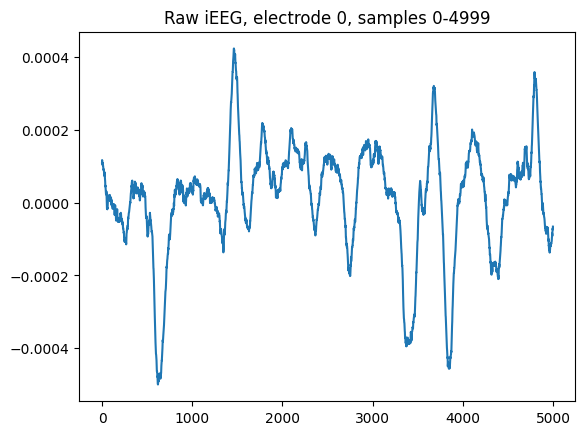

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  1.1min finished


<RawEDF | MS027_SWB.edf, 276 x 1123062 (2246.1 s), ~2.31 GB, data loaded>

### Notch filter line noise

In [11]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   10.3s finished


<RawEDF | MS027_SWB.edf, 276 x 1123062 (2246.1 s), ~2.31 GB, data loaded>

### Photodiode
- examine photodiode 

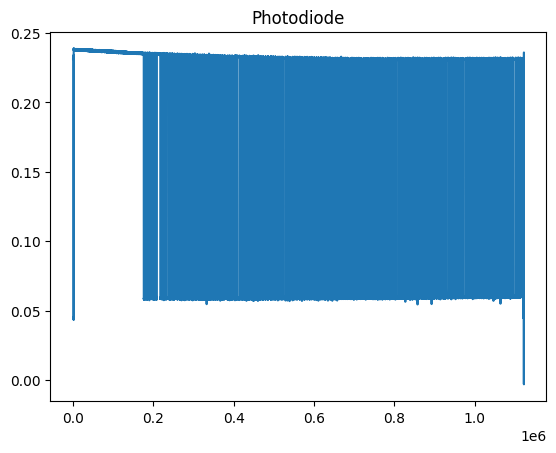

In [12]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [13]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/photodiode.fif
[done]


In [14]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS027_SWB.edf, 275 x 1123062 (2246.1 s), ~2.30 GB, data loaded>

### Anatomical Localization

In [15]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS027_SWB.edf, 275 x 1123062 (2246.1 s), ~2.30 GB, data loaded>

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Note
0,LaCaS1,A32sg_L,-1.996863,29.154473,-12.396027,-1.489100,25.800180,-10.918105,Gray,Left ACgG anterior cingulate gyrus,Area s24,L Olfactory cortex,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS2,A32sg_L,-2.396240,31.151354,-7.997437,-2.305976,28.213844,-6.269909,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus C,NaN,NaN
2,LaCaS3,A32sg_L,-3.194992,33.148236,-3.198975,-3.581341,30.463378,-1.114084,White,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Unknown,WM,NaN
3,LaCaS4,A24rv_L,-3.594368,35.145118,1.199615,-4.402200,32.551975,3.559879,White,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Unknown,WM,NaN
4,LaCaS5,A24rv_L,-4.393121,37.141999,5.598206,-5.612624,34.849006,8.272237,White,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Left cingulate gyrus F,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,RHplT8,A21c_R,50.321429,-29.953224,-17.194489,58.208197,-32.244283,-9.492322,Gray,Right Cerebral White Matter,Unknown,R Middle Temporal Gyrus,R MTG,Right inferior middle temporal gyrus D,NaN,NaN
144,RHplT9,A21c_R,54.315191,-32.748859,-15.994873,62.645023,-35.095643,-8.145739,Gray,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right inferior middle temporal gyrus D,NaN,NaN
145,RHplT10,A21c_R,58.308954,-35.145117,-15.195129,67.068103,-37.522830,-7.125109,Gray,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right inferior middle temporal gyrus E,OOB,NaN
146,RHplT11,A21c_R,62.702093,-37.940751,-13.995514,71.887967,-40.228714,-5.508332,Unknown,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right superior middle temporal gyrus E,OOB,NaN


In [17]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'LiIsP1',
 'LiIsP2',
 'LiIsP3',
 'LiIsP4',
 'LiIsP5',
 'LiIsP6',
 'LiIsP7',
 'LiIsP8',
 'LiIsP9',
 'LiIsP10',
 'LiIsP11',
 'LiIsP12',
 'LiIsP13',
 'LiIsP14',
 'LiIsP15',
 'LiIsP16',
 'Lence1',
 'Lence2',
 'Lence3',
 'Lence4',
 'Lence5',
 'Lence6',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LAglT10',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'Rm

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'lilsp1', 'lilsp2', 'lilsp3', 'lilsp4', 'lilsp5', 'lilsp6', 'lilsp7', 'lilsp8', 'lilsp9', 'lilsp10', 'lilsp11', 'lilsp12', 'lilsp13', 'lilsp14', 'lilsp15', 'lilsp16', 'ralsp1', 'ralsp2', 'ralsp3', 'ralsp4', 'ralsp5', 'ralsp6', 'ralsp7', 'ralsp8', 'ralsp9', 'ralsp10', 'ralsp11', 'ralsp12', 'ralsp13', 'ralsp14', 'ralsp15', 'ralsp16', 'lenc1', 'lenc2', 'lenc3', 'lenc4', 'lenc5', 'lenc6', 'c157', 'c158', 'c159', 'c160', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230',

In [19]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [20]:
unmatched_seeg #make sure there are no unmatched names


[]

In [21]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [22]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'lmolf10': 'lmolf10',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'rmolf10': 'rmolf10',
 'rmolf11': 'rmolf11',
 'rmolf12': 'rmolf12',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'racas11': 'racas11',
 'racas12': 'racas12',
 'lmcms1': 'lm

In [23]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS027_SWB.edf, 275 x 1123062 (2246.1 s), ~2.30 GB, data loaded>

In [24]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 74 left sEEG and 74 right sEEG electrodes
We have a total of 148 sEEG electrodes


In [25]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS027_SWB.edf, 275 x 1123062 (2246.1 s), ~2.30 GB, data loaded>

In [26]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS027_SWB.edf, 148 x 1123062 (2246.1 s), ~1.24 GB, data loaded>

In [27]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS027_SWB.edf, 148 x 1123062 (2246.1 s), ~1.24 GB, data loaded>

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'lacas': 12,
 'laglt': 10,
 'lence': 6,
 'lhplt': 10,
 'liisp': 16,
 'lmcms': 10,
 'lmolf': 10,
 'racas': 12,
 'raglt': 12,
 'raisp': 16,
 'rhplt': 12,
 'rmcms': 10,
 'rmolf': 12}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [32]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

In [31]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=30, scalings=mne_data._data.max()/20)


In [33]:
# mne_data.info['bads'] = ['raglt11', 'lence1', 'raglt12', 'racas10']

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [34]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [35]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [36]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=83, n_times=1123062
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas9-lacas10, lacas11-lacas12, lmcms1-lmcms2, lmcms2-lmcms3, lmolf1-lmolf2, lmolf2-lmolf3, lmolf3-lmolf4, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, lmolf8-lmolf9, lmolf9-lmolf10, liisp1-liisp2, liisp2-liisp3, liisp3-liisp4, liisp4-liisp5, liisp5-liisp6, liisp6-liisp7, liisp15-liisp16, lence2-lence3, lence3-lence4, lence4-lence5, lence5-lence6, laglt1-laglt2, laglt2-laglt3, laglt3-laglt4, laglt6-laglt7, laglt7-laglt8, laglt8-laglt9, lhplt1-lhplt2, lhplt2-lhplt3, racas1-racas2, racas2-racas3, racas5-racas6, racas6-racas7, racas10-racas11, rmcms1-rmcms2, rmcms2-rmcms3, rmcms3-rmcms4, rmcms4-rmcms5, rmcms5-rmcms6, rmcms6-rmcms7, rmcms7-rmcms8, rmolf2-rmolf3, rmolf3-rmo

In [37]:
mne_data_bp_reref

<RawEDF | MS027_SWB.edf, 83 x 1123062 (2246.1 s), ~711.3 MB, data loaded>

In [38]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'lacas11-lacas12',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmolf1-lmolf2',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'lmolf9-lmolf10',
 'liisp1-liisp2',
 'liisp2-liisp3',
 'liisp3-liisp4',
 'liisp4-liisp5',
 'liisp5-liisp6',
 'liisp6-liisp7',
 'liisp15-liisp16',
 'lence2-lence3',
 'lence3-lence4',
 'lence4-lence5',
 'lence5-lence6',
 'laglt1-laglt2',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt6-laglt7',
 'laglt7-laglt8',
 'laglt8-laglt9',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'racas1-racas2',
 'racas2-racas3',
 'racas5-racas6',
 'racas6-racas7',
 'racas10-racas11',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms3-rmcms4',
 'rmcms4-rmcms5',
 'rmcms5-rmcms6',
 'rmcms6-rmcms7',
 'rmcms7-rmcms8',
 'rmolf2-rmolf3',
 'rmolf3-rmolf4',
 'rmolf4-rmolf5',
 'rmolf5-rmolf6',
 'rmolf6-rmolf7',
 '

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


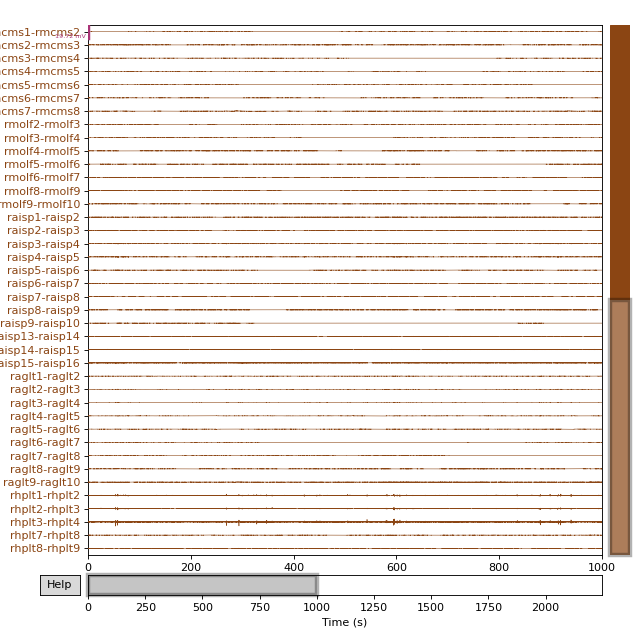

In [39]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


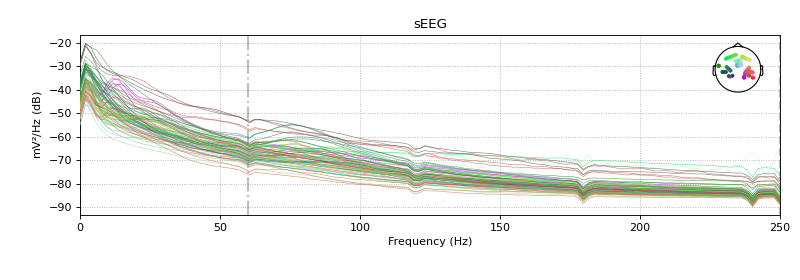

<IPython.core.display.Javascript object>


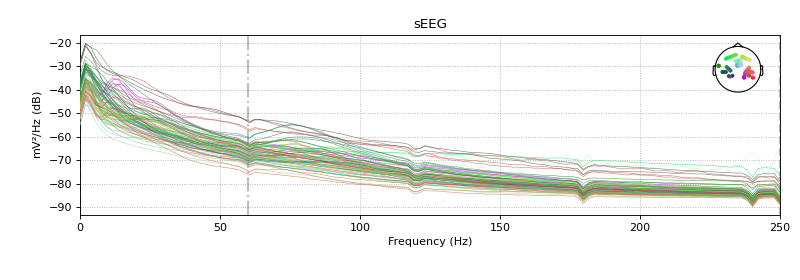

In [40]:
mne_data_bp_reref.compute_psd().plot()

## Save Reref Data

In [41]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/bp_ref_ieeg.fif
[done]


In [42]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [43]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 


In [44]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/photodiode.fif...
Isotrak not found
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...


In [45]:
photodiode_data

<Raw | photodiode.fif, 1 x 1123062 (2246.1 s), ~8.6 MB, data loaded>

<IPython.core.display.Javascript object>


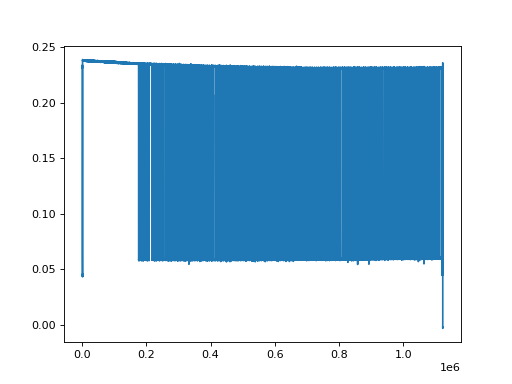

In [46]:
# plt.plot(scipy.stats.zscore(photodiode_data._data[0:]))
plt.plot(photodiode_data._data[0,:])
# plt.plot(temp_diode._data[1000000:1100000])
# plt.plot(temp_diode._data[1000000:1300000])
# plt.plot(temp_diode._data[:])
# plt.plot(scipy.stats.zscore(temp_diode._data[:]))
plt.show()

<IPython.core.display.Javascript object>


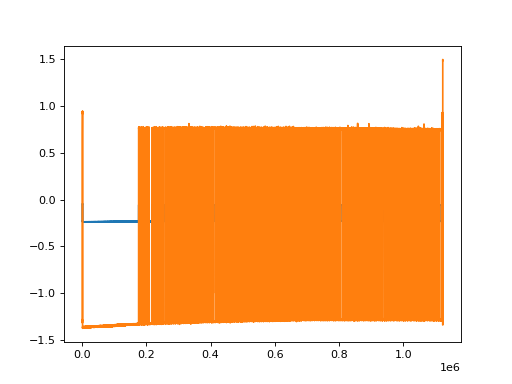

In [47]:
temp_diode = photodiode_data.copy()
temp_diode._data = -temp_diode._data[0,:]
# temp_diode._data[0:100000] = np.min(temp_diode._data[:])
plt.plot(temp_diode._data[:])
plt.plot(zscore(temp_diode._data[:]))
plt.show()

In [74]:
### Photodiode alignment
smoothSize=11
windSize=15
height=-1.3

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

45 blocks
.............................................

found matches for 15 of 676 pulses


In [75]:
print(slope, offset,smoothSize,windSize,height)

0.9999925299369319 3.9144780428619015 11 15 -1.3


In [76]:
# print(slope, offset,smoothSize,windSize,height)
# 1.0000067333950415 3.9377417384733917 11 15 0.7
# 1.0000057797049084 3.914327314701268 11 15 -1
# 1.0000060099145294 3.9257878381774844 11 15 0

In [65]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [66]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

<IPython.core.display.Javascript object>


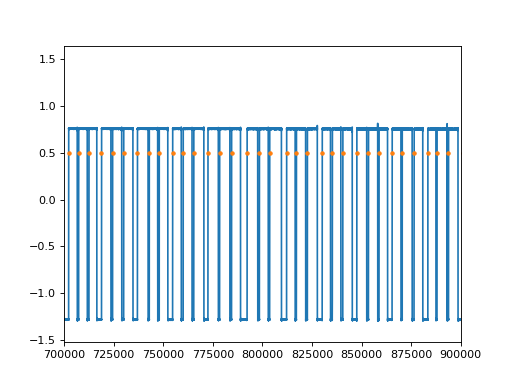

In [81]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')
plt.xlim([700000,900000])
plt.show()

In [77]:
print(slope,offset)

0.9999925299369319 3.9144780428619015


# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [82]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,util_dCPE_emmap,util_tCF_emmap,util_dCF_emmap,util_tRegret_emmap,util_dRegret_emmap,util_tRelief_emmap,util_dRelief_emmap,util_RPE_emmap,util_pRPE_emmap,util_nRPE_emmap
0,1,14.0,mix,430.764912,430.773696,433.870105,435.885927,3.096409,0.0,-0.50,...,0.313744,-0.205170,0.000000,0.000000,0.000000,0.518914,0.313744,0.205170,0.20517,0.000000
1,2,108.0,loss,440.435121,440.435893,443.315561,443.322754,2.879668,-0.2,-0.72,...,-0.221612,0.000000,0.000000,-0.221612,-0.221612,0.000000,0.000000,0.000000,0.00000,0.000000
2,3,138.0,loss,450.364908,450.365628,453.943284,453.950405,3.577657,-0.5,-1.80,...,-0.410340,0.000000,0.000000,-0.410340,-0.410340,0.000000,0.000000,0.000000,0.00000,0.000000
3,4,84.0,gain,470.083897,470.084694,472.950046,474.966335,2.865352,0.5,0.00,...,-0.091145,0.000000,0.627488,0.000000,0.000000,0.536343,-0.091145,0.000000,0.00000,0.000000
4,5,77.0,gain,480.241354,480.242106,483.960198,483.968428,3.718091,0.4,0.00,...,-0.043986,0.584054,0.584054,-0.043986,-0.043986,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,133.0,loss,2163.995097,2163.996122,2169.035162,2171.052038,5.039039,-0.5,-1.00,...,0.410340,-0.326970,-0.410340,0.000000,0.000000,0.326970,0.410340,0.326970,0.32697,0.000000
146,147,62.0,gain,2175.585131,2175.592078,2179.562990,2179.570656,3.970912,0.3,0.00,...,0.445090,0.000000,0.000000,0.000000,0.000000,0.445090,0.445090,0.000000,0.00000,0.000000
147,148,47.0,mix,2190.124242,2190.132279,2195.788264,2197.804533,5.655985,0.0,-1.10,...,-0.348609,0.849561,0.000000,-1.198170,-0.348609,0.000000,0.000000,-0.849561,0.00000,-0.849561
148,149,115.0,loss,2203.081590,2203.082328,2208.131137,2208.138938,5.048809,-0.3,-0.74,...,-0.024015,-0.267047,-0.267047,0.000000,0.000000,-0.024015,-0.024015,0.000000,0.00000,0.000000


In [83]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('gamble', 433.8701051999815, 435.88592660008),
 ('safe', 443.3155608000234, 443.3227542000823),
 ('safe', 453.9432844000403, 453.9504050000105),
 ('gamble', 472.9500464000739, 474.9663347001188),
 ('safe', 483.9601976000704, 483.9684284001123),
 ('gamble', 494.38869159994647, 496.4038416999392),
 ('safe', 510.8298575999215, 510.8375558000989),
 ('safe', 522.0234491999727, 522.0311819000635),
 ('gamble', 531.0857359999791, 533.1022443000693),
 ('gamble', 547.3267870000564, 549.3424533999059),
 ('gamble', 558.2380067000631, 560.2545598000288),
 ('safe', 569.1155552000273, 569.1228020000271),
 ('safe', 586.5398746000137, 586.5475598999765),
 ('gamble', 596.7673897999339, 598.7840684000403),
 ('safe', 607.9447075000498, 607.9526011000853),
 ('safe', 622.8706916000228, 622.8784433999099),
 ('safe', 633.5310541999061, 633.5383880001027),
 ('safe', 643.6428851000965, 643.6499689999036),
 ('safe', 656.1191867000889, 656.1269928000402),
 ('safe', 666.3309001000598, 666.3379891000222),
 ('gamb

In [84]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       435.870105
1       445.315561
2       455.943284
3       474.950046
4       485.960198
          ...     
145    2171.035162
146    2181.562990
147    2197.788264
148    2210.131137
149    2220.609368
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [85]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [86]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [87]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [88]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/bp_ref_ieeg.fif...
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    6.2s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/bp_ref_ieeg.fif...
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    5.6s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS027/bp_ref_ieeg.fif...
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    5.8s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [89]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~142.7 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~119.0 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~237.7 MB, data loaded,
  'CpeOnset': 150>}

In [134]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [90]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [91]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [92]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

In [93]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~142.7 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~119.0 MB, data loaded, with metadata,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~237.7 MB, data loaded, with metadata,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [94]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [95]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [96]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   25.4s finished


Adding metadata with 19 columns


In [97]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 83, ~1.39 GB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [98]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   23.2s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   35.0s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
Not setting metadata
Adding metadata with 19 columns


In [99]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 83, ~715.4 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 83, ~4.18 GB>}

In [100]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 83, ~715.4 MB>

In [101]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 83, ~4.18 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [102]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


05102024 3.9144780428619015


In [103]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    

Plot TFR for epoch:  DecisionOnset
Plot TFR for epoch:  CpeOnset
